Data Preprocessing


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


df = pd.read_csv('blood_test_dataset.csv')

# 1. Data Overview
print("Dataset Shape:", df.shape)
print("\nFeature Names:")
print(df.columns.tolist())
print("\nMissing Values:")
print(df.isnull().sum())

# 2. Data Preprocessing
# All features are already normalized (values between 0 and 1)
# No need for additional normalization

# 3. Label Encoding for the target variable
le = LabelEncoder()
df['Disease'] = le.fit_transform(df['Disease'])

# Store the mapping for future reference
disease_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nDisease Mapping:")
print(disease_mapping)

# 4. Split features and target
X = df.drop('Disease', axis=1)
y = df['Disease']

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Optional: Save preprocessed data
X_train.to_csv('preprocessed_X_train.csv', index=False)
X_test.to_csv('preprocessed_X_test.csv', index=False)
pd.Series(y_train).to_csv('preprocessed_y_train.csv', index=False)
pd.Series(y_test).to_csv('preprocessed_y_test.csv', index=False)

Dataset Shape: (2351, 25)

Feature Names:
['Glucose', 'Cholesterol', 'Hemoglobin', 'Platelets', 'White Blood Cells', 'Red Blood Cells', 'Hematocrit', 'Mean Corpuscular Volume', 'Mean Corpuscular Hemoglobin', 'Mean Corpuscular Hemoglobin Concentration', 'Insulin', 'BMI', 'Systolic Blood Pressure', 'Diastolic Blood Pressure', 'Triglycerides', 'HbA1c', 'LDL Cholesterol', 'HDL Cholesterol', 'ALT', 'AST', 'Heart Rate', 'Creatinine', 'Troponin', 'C-reactive Protein', 'Disease']

Missing Values:
Glucose                                      0
Cholesterol                                  0
Hemoglobin                                   0
Platelets                                    0
White Blood Cells                            0
Red Blood Cells                              0
Hematocrit                                   0
Mean Corpuscular Volume                      0
Mean Corpuscular Hemoglobin                  0
Mean Corpuscular Hemoglobin Concentration    0
Insulin                             

Feature Engineering


In [3]:

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif


correlation_matrix = df.drop('Disease', axis=1).corr()
high_correlations = np.where(np.abs(correlation_matrix) > 0.8)
high_correlations = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y]) 
                     for x, y in zip(*high_correlations) if x != y]

print("\nHighly Correlated Features (>0.8):")
for feat1, feat2, corr in high_correlations:
    print(f"{feat1} -- {feat2}: {corr:.3f}")

# Create interaction features
# Example: Multiply related features
df['Cholesterol_HDL_Ratio'] = df['Cholesterol'] / (df['HDL Cholesterol'] + 1e-6)
df['Glucose_Insulin_Interaction'] = df['Glucose'] * df['Insulin']
df['Blood_Pressure_Product'] = df['Systolic Blood Pressure'] * df['Diastolic Blood Pressure']
df['RBC_HGB_Interaction'] = df['Red Blood Cells'] * df['Hemoglobin']

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_numeric = df.drop('Disease', axis=1)
X_pca = pca.fit_transform(X_numeric)

print("\nPCA Results:")
print(f"Original features: {X_numeric.shape[1]}")
print(f"PCA features: {X_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.cumsum()[-1]:.3f}")

# Feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=15)
X_selected = selector.fit_transform(X_numeric, df['Disease'])

# Get selected feature names
selected_features = X_numeric.columns[selector.get_support()].tolist()
print("\nTop 15 Selected Features:")
print(selected_features)




Highly Correlated Features (>0.8):

PCA Results:
Original features: 28
PCA features: 18
Explained variance ratio: 0.953

Top 15 Selected Features:
['Glucose', 'Cholesterol', 'Platelets', 'White Blood Cells', 'Red Blood Cells', 'Hematocrit', 'Mean Corpuscular Volume', 'Mean Corpuscular Hemoglobin', 'BMI', 'HDL Cholesterol', 'ALT', 'Troponin', 'Cholesterol_HDL_Ratio', 'Glucose_Insulin_Interaction', 'RBC_HGB_Interaction']


Model Training

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import joblib

# 1. Load and prepare the full dataset for training
df = pd.read_csv('blood_test_dataset.csv')

# 2. Prepare the data
X = df.drop('Disease', axis=1)  # Features (blood test results)
le = LabelEncoder()
y = le.fit_transform(df['Disease'])  # Target (disease labels)

# Save the label encoder for future use
joblib.dump(le, 'disease_label_encoder.joblib')

# 3. Train the model on the entire dataset
xgb = XGBClassifier(
    objective='multi:softprob',
    random_state=42,
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=8,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.9
)

# Train on full dataset
xgb.fit(X, y)

# Save the trained model
joblib.dump(xgb, 'disease_prediction_model.joblib')

# 4. Create a prediction function
def predict_disease(blood_test_results):
    """
    Predict disease from blood test results.
    
    Parameters:
    blood_test_results : dict
        Dictionary containing blood test parameters
        
    Returns:
    dict : Prediction results including disease and confidence
    """
    # Load the model and label encoder
    model = joblib.load('disease_prediction_model.joblib')
    le = joblib.load('disease_label_encoder.joblib')
    
    # Convert input to DataFrame
    df_input = pd.DataFrame([blood_test_results])
    
    # Ensure all required features are present
    required_features = X.columns.tolist()
    missing_features = set(required_features) - set(df_input.columns)
    if missing_features:
        raise ValueError(f"Missing required features: {missing_features}")
    
    # Reorder columns to match training data
    df_input = df_input[required_features]
    
    # Make prediction
    prediction = model.predict(df_input)[0]
    probabilities = model.predict_proba(df_input)[0]
    
    # Get disease name and probabilities
    disease_name = le.inverse_transform([prediction])[0]
    disease_probabilities = dict(zip(le.classes_, probabilities))
    
    return {
        'predicted_disease': disease_name,
        'confidence': probabilities[prediction],
        'all_probabilities': disease_probabilities
    }

# Example usage:
print("\nExample of how to use the model:")
print("Required blood test parameters:", list(X.columns))

# Example blood test result
example_blood_test = {
    'Glucose': 0.739,
    'Cholesterol': 0.650,
    'HDL Cholesterol': 0.500,
    'LDL Cholesterol': 0.600,
    # ... add all required parameters ...
}

# Show how to make a prediction
print("\nMaking a prediction with example data:")
try:
    result = predict_disease(example_blood_test)
    print(f"\nPredicted Disease: {result['predicted_disease']}")
    print(f"Confidence: {result['confidence']:.3f}")
    print("\nProbability for each disease:")
    for disease, prob in result['all_probabilities'].items():
        print(f"{disease}: {prob:.3f}")
except ValueError as e:
    print(f"Error: {e}")
    print("\nPlease provide all required blood test parameters.")


Example of how to use the model:
Required blood test parameters: ['Glucose', 'Cholesterol', 'Hemoglobin', 'Platelets', 'White Blood Cells', 'Red Blood Cells', 'Hematocrit', 'Mean Corpuscular Volume', 'Mean Corpuscular Hemoglobin', 'Mean Corpuscular Hemoglobin Concentration', 'Insulin', 'BMI', 'Systolic Blood Pressure', 'Diastolic Blood Pressure', 'Triglycerides', 'HbA1c', 'LDL Cholesterol', 'HDL Cholesterol', 'ALT', 'AST', 'Heart Rate', 'Creatinine', 'Troponin', 'C-reactive Protein']

Making a prediction with example data:
Error: Missing required features: {'Insulin', 'Mean Corpuscular Hemoglobin Concentration', 'Systolic Blood Pressure', 'Platelets', 'BMI', 'C-reactive Protein', 'Red Blood Cells', 'Creatinine', 'Triglycerides', 'Heart Rate', 'Troponin', 'White Blood Cells', 'Mean Corpuscular Volume', 'Hematocrit', 'AST', 'Diastolic Blood Pressure', 'Mean Corpuscular Hemoglobin', 'ALT', 'HbA1c', 'Hemoglobin'}

Please provide all required blood test parameters.


Model Use

In [5]:
# 1. Load the required libraries
import pandas as pd
import joblib

# 2. Input new blood test results
new_blood_test = {
    'Glucose': 0.121,
    'Cholesterol': 0.023,
    'Hemoglobin': 0.944,
    'Platelets': 0.905,
    'White Blood Cells': 0.507,  
    'Red Blood Cells': 0.403,   
    'Hematocrit': 0.164,
    'Mean Corpuscular Volume': 0.307,
    'Mean Corpuscular Hemoglobin': 0.207,
    'Mean Corpuscular Hemoglobin Concentration': 0.505,
    'Insulin': 0.571,
    'BMI': 0.839,
    'Systolic Blood Pressure': 0.580,
    'Diastolic Blood Pressure': 0.556,
    'Triglycerides': 0.477,
    'HbA1c': 0.856,
    'LDL Cholesterol': 0.652,
    'HDL Cholesterol': 0.106,
    'ALT': 0.942,
    'AST': 0.344,
    'Heart Rate': 0.666,
    'Creatinine': 0.659,
    'Troponin': 0.5,  # Added missing feature
    'C-reactive Protein': 0.401
}

# 3. Make prediction
def predict_disease(blood_test_results):
    # Load the saved model and label encoder
    model = joblib.load('disease_prediction_model.joblib')
    le = joblib.load('disease_label_encoder.joblib')
    
    # Convert to DataFrame
    df_input = pd.DataFrame([blood_test_results])
    
    # Make prediction
    prediction = model.predict(df_input)[0]
    probabilities = model.predict_proba(df_input)[0]
    
    # Get disease name
    disease_name = le.inverse_transform([prediction])[0]
    
    return {
        'disease': disease_name,
        'confidence': probabilities[prediction]
    }

# 4. Get prediction
result = predict_disease(new_blood_test)
print(f"Predicted Disease: {result['disease']}")
print(f"Confidence: {result['confidence']:.3f}")

Predicted Disease: Diabetes
Confidence: 0.996


Explainable alternate

Error in SHAP explanation: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).


<Figure size 1200x800 with 0 Axes>

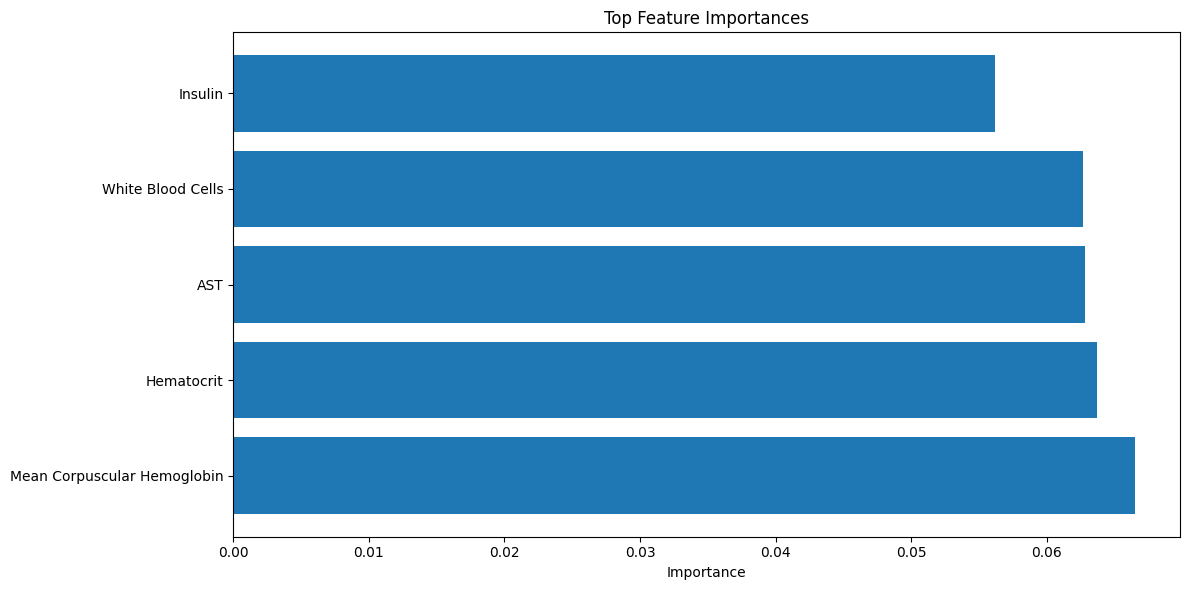


Predicted Disease: Diabetes
Confidence: 0.996

Top Contributing Features:
Mean Corpuscular Hemoglobin: 0.0665
Hematocrit: 0.0637
AST: 0.0629
White Blood Cells: 0.0627
Insulin: 0.0562


In [6]:
import shap
import numpy as np
import matplotlib.pyplot as plt

def explain_prediction(model, input_data, feature_names):
    # Convert feature_names to list
    feature_names = list(feature_names)
    
    # Ensure input_data is properly formatted
    if isinstance(input_data, dict):
        input_data = pd.DataFrame([input_data])
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    try:
        # Calculate SHAP values
        shap_values = explainer.shap_values(input_data)
        
        # Create visualization - updated for SHAP v0.20+
        plt.figure(figsize=(12, 8))
        if isinstance(shap_values, list):  # Multi-class case
            # Plot SHAP values for the predicted class
            prediction = model.predict(input_data)[0]
            shap.plots.force(
                explainer.expected_value[prediction],
                shap_values[prediction],
                input_data,
                feature_names=feature_names,
                matplotlib=True,
                show=False
            )
        else:  # Binary classification case
            shap.plots.force(
                explainer.expected_value,
                shap_values,
                input_data,
                feature_names=feature_names,
                matplotlib=True,
                show=False
            )
        plt.tight_layout()
        plt.show()
        
        # Calculate feature importance
        if isinstance(shap_values, list):
            importance_values = np.abs(np.array(shap_values)).mean(axis=0)[0]
        else:
            importance_values = np.abs(shap_values)[0]
        
        # Create importance dictionaries
        feature_importance_dict = dict(zip(feature_names, importance_values))
        top_features = dict(sorted(
            feature_importance_dict.items(), 
            key=lambda x: abs(x[1]), 
            reverse=True
        )[:5])
        
        return {
            'top_features': top_features,
            'feature_importance': feature_importance_dict
        }
        
    except Exception as e:
        print(f"Error in SHAP explanation: {str(e)}")
        # Fallback to basic feature importance
        importances = model.feature_importances_
        feature_importance_dict = dict(zip(feature_names, importances))
        top_features = dict(sorted(
            feature_importance_dict.items(), 
            key=lambda x: x[1], 
            reverse=True
        )[:5])
        
        # Create a simple bar plot of feature importances
        plt.figure(figsize=(12, 6))
        features, values = zip(*top_features.items())
        plt.barh(features, values)
        plt.title('Top Feature Importances')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
        
        return {
            'top_features': top_features,
            'feature_importance': feature_importance_dict
        }

# The rest of the code remains the same
def get_prediction_explanation(blood_test_results):
    model = joblib.load('disease_prediction_model.joblib')
    le = joblib.load('disease_label_encoder.joblib')
    
    input_data = pd.DataFrame([blood_test_results])
    prediction = model.predict(input_data)[0]
    probabilities = model.predict_proba(input_data)[0]
    disease_name = le.inverse_transform([prediction])[0]
    
    explanation = explain_prediction(model, input_data, list(blood_test_results.keys()))
    
    return {
        'prediction': disease_name,
        'confidence': probabilities[prediction],
        'top_contributing_features': explanation['top_features'],
        'feature_importance': explanation['feature_importance']
    }

# Example usage
result = get_prediction_explanation(new_blood_test)
print(f"\nPredicted Disease: {result['prediction']}")
print(f"Confidence: {result['confidence']:.3f}")
print("\nTop Contributing Features:")
for feature, importance in result['top_contributing_features'].items():
    print(f"{feature}: {abs(importance):.4f}")